##Getting employment data from the Bureau of Labor Statistics API

By using [this example Python code](https://www.bls.gov/developers/api_python.htm#python2)
In particular, we are interested in the [popular series](https://data.bls.gov/cgi-bin/surveymost?bls) titled:
- Unemployment Rate (Seasonally Adjusted)
- PPI Final Demand (Seasonally Adjusted), PPI = producer price index

Here's what we need to see:
- Use the API to obtain the data from 2011 to 2022.
- Consolidate results into two variables: `unemployment` and `ppi`.

Description:

There are several reports on the happiness level of young adults have decreased the most compared to all other age groups.

Here we will examine the [Behavior Risk Factors and Surveillance System (BRFSS) survey data from 2022](https://www.cdc.gov/brfss/annual_data/annual_2022.html) and try to see its relationship to various economic indicators.

In [ ]:
import requests
import json

In [ ]:
headers = {'Content-type': 'application/json'}
periods = [(2011, 2018), (2019, 2022)] #we can only obtain a limited number of records from BLS so one approach is to query the years 2011-2018, then 2019-2022.
unemployment = []
ppi = []
for period in periods:
  data1 = json.dumps({"seriesid": ['LNS14000000','WPSFD4'],"startyear":period[0], "endyear":period[1]})
  p = requests.post('https://api.bls.gov/publicAPI/v2/timeseries/data/', data=data1,  headers=headers)
  dat = p.json()
  for serie in dat['Results']['series']:
    if serie['seriesID'] == 'LNS14000000':
      unemployment.extend(serie['data'])
    else:
      ppi.extend(serie['data'])

In [ ]:
dat = p.json()
type(dat)

dict

In [ ]:
dat.keys()

dict_keys(['status', 'responseTime', 'message', 'Results'])

In [1]:
#dat['Results']['series'][0]

In [ ]:
serie.keys()

dict_keys(['seriesID', 'data'])

In [ ]:
len(unemployment)

144

In [ ]:
unemployment[:4]

[{'year': '2018',
  'period': 'M12',
  'periodName': 'December',
  'value': '3.9',
  'footnotes': [{}]},
 {'year': '2018',
  'period': 'M11',
  'periodName': 'November',
  'value': '3.8',
  'footnotes': [{}]},
 {'year': '2018',
  'period': 'M10',
  'periodName': 'October',
  'value': '3.8',
  'footnotes': [{}]},
 {'year': '2018',
  'period': 'M09',
  'periodName': 'September',
  'value': '3.7',
  'footnotes': [{}]}]

###Tidying the data

Create a data frame called `labor` that contains the information from above. Each row should be a year-month and the columns should include:
- `ppi`, this should be a float
- `unemployment`, this should be a float
- `date`, this should be a datetime object

In [ ]:
import pandas as pd

In [ ]:
df1 = pd.DataFrame(ppi)

In [ ]:
df1.head()
df1.rename(columns = {'value': 'ppi'})

,year,period,periodName,ppi,footnotes
0,2018,M12,December,117.4,[{}]
1,2018,M11,November,117.4,[{}]
2,2018,M10,October,117.5,[{}]
3,2018,M09,September,116.7,[{}]
4,2018,M08,August,116.5,[{}]
...,...,...,...,...,...
139,2019,M05,May,118.3,[{}]
140,2019,M04,April,118.2,[{}]
141,2019,M03,March,117.6,[{}]
142,2019,M02,February,117.2,[{}]


In [ ]:
df2 = pd.DataFrame(unemployment)
df2.shape

(144, 5)

In [ ]:
labor = pd.merge(df1, df2, on = ['year', 'period', 'periodName'], how = 'left')


In [ ]:
labor['date'] = pd.to_datetime(labor['year'] + '-' + labor['periodName'] + '-01')
#labor['date'] = labor.apply(lambda x: x['year'] + '-' + x['period'][1:] + '-01', axis = 1)
#labor['date'] = pd.to_datetime(labor['date'])

In [ ]:
labor = labor.rename(columns = {'value_x': 'ppi'})

In [ ]:
labor = labor.rename(columns = {'value_y' : 'unemployment'})

In [ ]:
labor.head()

,year,period,periodName,ppi,footnotes_x,unemployment,footnotes_y,date
0,2018,M12,December,117.4,[{}],3.9,[{}],2018-12-01
1,2018,M11,November,117.4,[{}],3.8,[{}],2018-11-01
2,2018,M10,October,117.5,[{}],3.8,[{}],2018-10-01
3,2018,M09,September,116.7,[{}],3.7,[{}],2018-09-01
4,2018,M08,August,116.5,[{}],3.8,[{}],2018-08-01


In [ ]:
labor['ppi'] = labor['ppi'].astype(float)
labor['unemployment'] = labor['unemployment'].astype(float)

In [ ]:
labor.shape

(144, 8)

In [ ]:
# Check for missing values
assert not labor.isnull().any().any(), "There are missing values in the DataFrame"

# Check for duplicate entries
assert not labor.duplicated(subset=['ppi', 'unemployment']).any(), "There are duplicate entries in the DataFrame"


AssertionError: ignored

In [ ]:
# Step 1: Find the maximum unemployment rate
max_unemployment = labor['unemployment'].max()

# Step 2: Filter the DataFrame to get the rows with the maximum unemployment rate
rows_with_max_unemployment = labor[labor['unemployment'] == max_unemployment]

# Display the resulting rows
print(rows_with_max_unemployment)
labor.drop(columns = ['periodName', 'footnotes_x', 'footnotes_y'], inplace=True)

     year period periodName    ppi footnotes_x  unemployment footnotes_y  \
128  2020    M04      April  116.6        [{}]          14.7        [{}]   

          date  
128 2020-04-01  


In [ ]:
labor.shape

(144, 5)

In [ ]:
labor.head()

,year,period,ppi,unemployment,date
0,2018,M12,117.4,3.9,2018-12-01
1,2018,M11,117.4,3.8,2018-11-01
2,2018,M10,117.5,3.8,2018-10-01
3,2018,M09,116.7,3.7,2018-09-01
4,2018,M08,116.5,3.8,2018-08-01


##Wrangling

To get the mental health data across years, we'll need to extract it from `exam_brfss_asc.json`.

Each record is one survey response from the BRFSS. The data is a single string where different characters contain the data for different variables. To know which variable correspond to which characters, we'll need to look at `exam_layout.csv`.

the definition of each variable is at [code book on the CDC](https://www.cdc.gov/brfss/annual_data/2021/pdf/codebook21_llcp-v2-508.pdf).

- `down30`, the value associated with the description "Now thinking about your mental health, which includes stress, depression, and problems with emotions, for how many days during the past 30 days was your mental health not good?"
- `age_group`, the integer associated with the variable `_AGEG5YR`
- `year`, the interview year, this may differ from the year in the JSON file.
- `month`, the interview month


In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
file_path = ("/content/drive/MyDrive/exam_brfss_asc.json")
import json
with open(file_path, 'r') as f:
  brfss = json.load(f)

In [ ]:
brfss.keys()

dict_keys(['2016', '2018', '2021', '2014', '2020', '2015', '2017', '2012', '2019', '2013', '2022'])

In [ ]:
brfss['2016'][:1]

['2   188   222110088521020500082014  0601521022201622102016  50288       88   0122 1201602783821132014506577109532832311312016027838         1212236332.0200362332.020036']

In [ ]:
df_layout = pd.read_csv("/content/drive/MyDrive/exam_layout.csv")

In [ ]:
df_layout.head()

,Unnamed: 0,Variable Name,Field Length,Starting Column
0,0,ASTHMA3,1,0
1,1,ASTHNOW,1,1
2,2,CASTHDX2,1,2
3,3,CASTHNO2,1,3
4,4,CHECKUP1,1,4


In [ ]:
vars_wanted = ['_AGEG5YR', 'MENTHLTH', 'IYEAR', 'IMONTH']
is_wanted = df_layout['Variable Name'].apply(lambda x: x in vars_wanted)

In [ ]:
is_wanted.sum()

4

In [ ]:
s_layout = df_layout.loc[is_wanted, :]

In [ ]:
record = brfss['2016'][0]

In [ ]:
s_layout = s_layout.reset_index()

In [ ]:
s_layout

,index,Unnamed: 0,Variable Name,Field Length,Starting Column
0,24,24,IMONTH,2,52
1,25,25,IYEAR,4,54
2,29,29,MENTHLTH,2,63
3,50,50,_AGEG5YR,2,108


In [ ]:
def grab_vars(record, slayout):
  bag = {}
  field_maps = {'MENTHLTH': 'down30',
              '_AGEG5YR': 'age_group',
              'IYEAR': 'year',
              'IMONTH': 'month'
}
  for i, row in s_layout.iterrows():
    start = row['Starting Column']
    end = row['Starting Column'] + row['Field Length']
    bag.update({field_maps[row['Variable Name']]: record[start:end]})
  return bag


In [ ]:

bag2 = []
for year in brfss:
  y_m = brfss[year]
  for record in y_m:
    bag2.append(grab_vars(record, s_layout))

In [ ]:
health = pd.DataFrame(bag2)

In [ ]:
health.groupby('year').value_counts()

year  month  down30  age_group
2012  10     88      09           116
      02     88      10            96
      07     88      09            95
      03     88      09            88
                     08            87
                                 ... 
2023  01     20      13             1
             22      02             1
             25      10             1
             29      05             1
                     10             1
Length: 20120, dtype: int64

In [ ]:
health.head()

,month,year,down30,age_group
0,10,2016,88,09
1,06,2016,30,08
2,04,2016,88,04
3,07,2016,88,10
4,11,2016,01,01


## Tidying up

- Verify there are no missing values in `year` or `month`

  - `down30`:
    - The value that corresponds to `None` implies 0 days, replace those values with 0.
    - Convert "Refused", "Don’t know/Not sure", and "Not asked or Missing" into missing values.
  - `age_group`
    - Simplify the groups into 3 categories: 18-34, 35-64, and others
- Aggregate the data into a data frame `health_agg` such that each row is a month/year/age group combination.

In [ ]:
assert health.year.isna().sum() == 0
assert health.month.isna().sum() == 0

In [ ]:
health.down30.value_counts()

88    78603
30     6621
02     5824
05     4523
01     3710
03     3582
10     3298
15     3017
20     1849
04     1834
07     1754
77     1612
14      649
25      605
99      516
06      487
08      337
12      264
28      179
21      133
29       94
09       77
18       67
16       52
27       46
13       45
17       41
22       34
23       29
24       26
11       26
26       20
19        9
Name: down30, dtype: int64

In [ ]:
health.dtypes

month        object
year         object
down30       object
age_group    object
dtype: object

In [ ]:
is_none = health.down30 == '88'
is_77 = health.down30 == '77'
is_99 = health.down30 == '99'
is_blank = health.down30 == ''
import numpy as np
health.loc[is_77|is_99|is_blank, 'down30'] = np.nan
health.loc[is_none, 'down30'] = '0'

In [ ]:
health.dtypes

month        object
year         object
down30       object
age_group    object
dtype: object

In [ ]:
health.age_group.value_counts()

09    13105
10    12614
08    11664
11    10915
07    10077
13     9705
06     8110
12     7915
05     7446
04     7330
01     6833
03     6656
02     5784
14     1809
Name: age_group, dtype: int64

In [ ]:
health['down30'] = pd.to_numeric(health['down30'], errors='coerce')

In [ ]:
health.dtypes

month         object
year          object
down30       float64
age_group     object
dtype: object

In [ ]:
ag = health.age_group.astype(int)
is_young = ag <= 3
is_okay = (ag >= 4) & (ag <= 9)
is_other = ag >= 10

In [ ]:
is_other.sum() + is_okay.sum()

100690

In [ ]:
health.loc[is_young, 'age_group'] = '18-34'
health.loc[is_okay, 'age_group'] = '35-64'
health.loc[is_other, 'age_group'] = 'others'

In [ ]:
health.age_group.value_counts()

35-64     57732
others    42958
18-34     19273
Name: age_group, dtype: int64

In [ ]:
# health['age_group'] = pd.to_numeric(health['age_group'], errors = 'coerce')
# for age in health.age_group:
#   if 1 <= age <= 3:
#     age == '18-34'
#   elif 4 <= age <= 9:
#     age == '35-64'
#   else:
#     age == 'others'

# health.head()

In [ ]:
health['down30'] = health.down30.astype(float)

In [ ]:
health_agg = health.groupby(['year', 'month', 'age_group']).mean().reset_index()

In [ ]:
health_agg['date'] = pd.to_datetime(health_agg['year'] + '-' + health_agg['month'] + '-01')

In [ ]:
health_agg = health_agg.rename(columns = {'down30':'simple_mean_down30'})

In [ ]:
health_agg.dtypes

year                          object
month                         object
age_group                     object
simple_mean_down30           float64
date                  datetime64[ns]
dtype: object

In [ ]:
is_young == '18-34'
is_2022 == health_agg.date.dt.year == 2022
#is_2022 = health_agg.year == '2022'
health_agg.loc[is_young & is_2022, :]

ValueError: ignored

In [ ]:
print(health_agg[(health_agg['age_group'] == '18-34') & (health_agg['year'] == '2022')])

     year month age_group  simple_mean_down30       date
360  2022    01     18-34            6.218750 2022-01-01
363  2022    02     18-34            5.034247 2022-02-01
366  2022    03     18-34            6.135294 2022-03-01
369  2022    04     18-34            7.064000 2022-04-01
372  2022    05     18-34            5.326389 2022-05-01
375  2022    06     18-34            6.513158 2022-06-01
378  2022    07     18-34            6.246154 2022-07-01
381  2022    08     18-34            6.871166 2022-08-01
384  2022    09     18-34            5.993464 2022-09-01
387  2022    10     18-34            5.758621 2022-10-01
390  2022    11     18-34            7.860606 2022-11-01
393  2022    12     18-34            6.027211 2022-12-01


## Observing patterns

- Is the 18-34 age group experiencing a larger decrease in mental health relative to other age groups?
- Comparing prices vs unemployment, which one seems more correlated with the changes in mental health of the 18-34 age group?

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns

In [ ]:
age_group_18_34 = health_agg[health_agg['age_group'] == '18-34']

In [ ]:
age_group_18_34.dtypes

year                          object
month                         object
age_group                     object
simple_mean_down30           float64
date                  datetime64[ns]
dtype: object

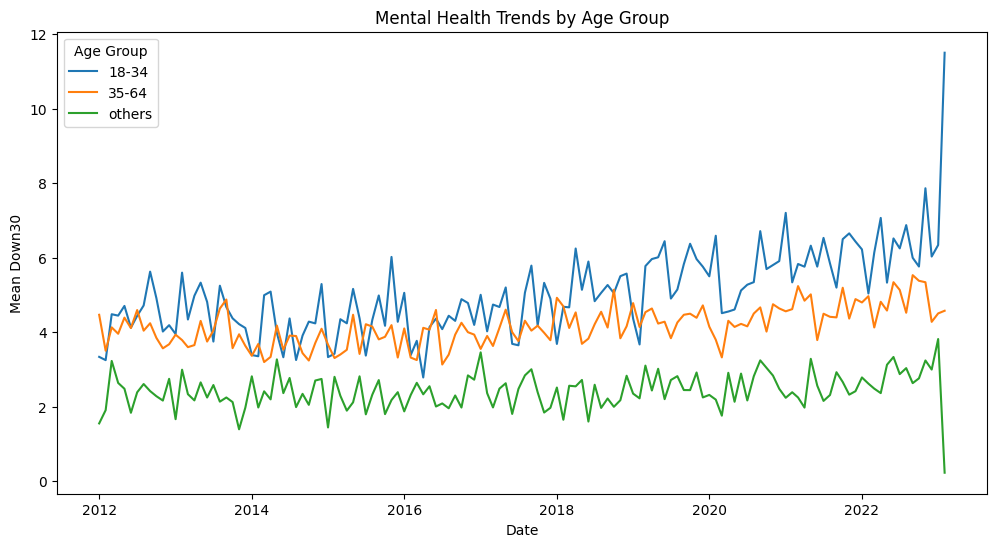

In [ ]:
plt.figure(figsize=(12, 6))
sns.lineplot(data=health_agg, x='date', y='simple_mean_down30', hue='age_group')
plt.title('Mental Health Trends by Age Group')
plt.xlabel('Date')
plt.ylabel('Mean Down30')
plt.legend(title='Age Group')
plt.show()

In [ ]:
mdf = labor.merge(health_agg, on = 'date')

In [ ]:
mdf.shape

(396, 9)

In [ ]:
labor.shape

(144, 5)

In [ ]:
health_agg.shape

(402, 5)

In [ ]:
mdf.head()

,year_x,period,ppi,unemployment,date,year_y,month,age_group,simple_mean_down30
0,2018,M12,117.4,3.9,2018-12-01,2018,12,18-34,5.569343
1,2018,M12,117.4,3.9,2018-12-01,2018,12,35-64,4.154348
2,2018,M12,117.4,3.9,2018-12-01,2018,12,others,2.826347
3,2018,M11,117.4,3.8,2018-11-01,2018,11,18-34,5.500000
4,2018,M11,117.4,3.8,2018-11-01,2018,11,35-64,3.832230


In [ ]:
mdf.unemployment.corr(mdf.simple_mean_down30)

-0.10638031266842676

<Axes: xlabel='unemployment', ylabel='simple_mean_down30'>

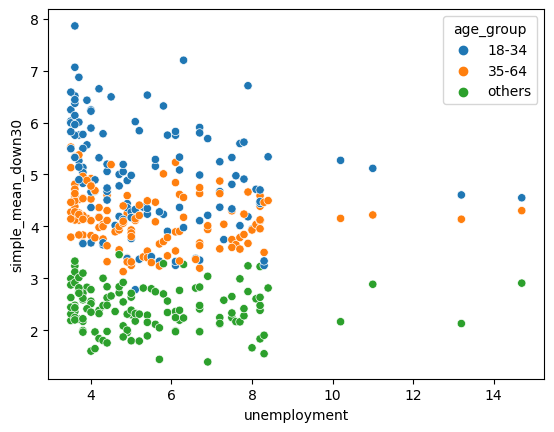

In [ ]:
sns.scatterplot(data = mdf, x = 'unemployment', y = 'simple_mean_down30', hue = 'age_group')